In [1]:
%matplotlib inline
import numpy as np

from scipy.stats import linregress
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import seaborn
import pandas as pd

In [2]:
# Load the data from Excel, remove data points that are not comparable.
raw_kin_df = pd.read_excel('01152018rubisco_kinetics.xlsx', index_col=0)
wt_only_df = raw_kin_df[raw_kin_df.mutant == False]

# Some measurements are made at much higher temps and are not comparable.
# TODO: collect pH of measurements so we can restrict to similar range
high_T = wt_only_df.Temp_C > 30
wt_only_df = wt_only_df.loc[np.logical_not(high_T)]

# Filtered DataFrame used for most plots below.
# Only variants with all the data
kin_df = wt_only_df.copy()
has_KMs = np.logical_and(np.isfinite(kin_df.Kc), np.isfinite(kin_df.Ko))
has_kcats = np.logical_and(np.isfinite(kin_df.Vc), np.isfinite(kin_df.Vo))
has_kons = np.logical_and(np.isfinite(kin_df.kon_C), np.isfinite(kin_df.kon_O))
has_all = np.logical_and(np.logical_and(has_KMs, has_kcats), has_kons)
kin_df = kin_df[has_all]

# Want to split data in various ways
# Savir vs. Non-Savir (mostly new) data
savir_df = wt_only_df[wt_only_df.savir]
nonsavir_df = wt_only_df[wt_only_df.savir == False]

# Group by RuBisCO form
grouped_form = wt_only_df.groupby('form_text')

# Markers we use for plotting below.
markers = 'o><^dsphH*'

In [3]:
print wt_only_df.shape[0], 'total WT RuBisCOs'
print kin_df.shape[0], 'RuBisCOs with all core kinetic data measured'

158 total WT RuBisCOs
136 RuBisCOs with all core kinetic data measured


In [4]:
# Perform PCA on kin_df - the subset of the data for which we have all values.
# Here we are doing this on all the data, including all the RuBisCO isoforms
vC_vals = kin_df.Vc.values
Kc_vals = kin_df.Kc.values
S_vals = kin_df.S.values
Kc_Ko_vals = Kc_vals / kin_df.Ko.values

# Careful here: input data should have samples along rows, features along cols.
data = np.vstack([vC_vals, Kc_vals, S_vals, Kc_Ko_vals]).T
log_data = np.log(data)

pca = PCA(n_components=2)
fitted = pca.fit(log_data)

In [5]:
pct_variance_explained = 100*fitted.explained_variance_ratio_

print "$1^{st}$ PC explains %.1f%% of variance" % pct_variance_explained[0]
print "$2^{nd}$ PC explains %.1f%% of variance" % pct_variance_explained[1]

complist = tuple(fitted.components_[0].tolist())
print 'PC1 %.2g *log(vC) + %.2g *log(KC) + %.2g *log(S) + %.2g *log(KC/KO)' % complist

complist = tuple(fitted.components_[1].tolist())
print 'PC2 %.2g *log(vC) + %.2g *log(KC) + %.2g *log(S) + %.2g *log(KC/KO)' % complist


$1^{st}$ PC explains 76.0% of variance
$2^{nd}$ PC explains 14.5% of variance
PC1 0.035 *log(vC) + 0.48 *log(KC) + -0.47 *log(S) + 0.74 *log(KC/KO)
PC2 -0.67 *log(vC) + -0.6 *log(KC) + -0.42 *log(S) + 0.15 *log(KC/KO)


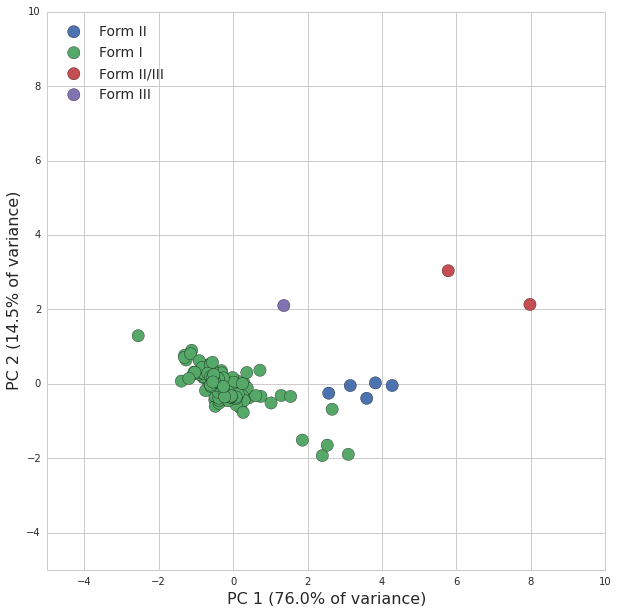

In [6]:
fig = plt.figure(figsize=(10,10))
colors = seaborn.color_palette()
seaborn.set_style('whitegrid')

transformed = fitted.transform(log_data)
forms = kin_df.form_text.unique()
colormapping = dict((forms[i], colors[i]) for i in xrange(len(forms)))
colors = [colormapping[f] for f in kin_df.form_text]

for form in forms:
    idxs = np.where(kin_df.form_text == form)
    color = colormapping[form]
    l = 'Form %s' % form
    plt.scatter(transformed[idxs, 0], transformed[idxs, 1], s=150, c=color, label=l)

plt.xlabel('PC 1 (%.1f%% of variance)' % pct_variance_explained[0], fontsize=16)
plt.ylabel('PC 2 (%.1f%% of variance)' % pct_variance_explained[1], fontsize=16)

plt.legend(loc=2, fontsize=14)
plt.xlim(-5, 10)
plt.ylim(-5, 10)

plt.show()

In [7]:
# Perform PCA on form I rubiscos for which we have all data.
F1s = kin_df[kin_df.form_text == 'I']
vC_vals = F1s.Vc.values
Kc_vals = F1s.Kc.values
S_vals = F1s.S.values
Kc_Ko_vals = Kc_vals / F1s.Ko.values

# Careful here: input data should have samples along rows, features along cols.
data = np.vstack([vC_vals, Kc_vals, S_vals, Kc_Ko_vals]).T
log_data = np.log(data)

pca = PCA(n_components=2)
fitted = pca.fit(log_data)

pct_variance_explained = 100*fitted.explained_variance_ratio_

print "$1^{st}$ PC explains %.1f%% of variance" % pct_variance_explained[0]
print "$2^{nd}$ PC explains %.1f%% of variance" % pct_variance_explained[1]

complist = tuple(fitted.components_[0].tolist())
print 'PC1 %.2g *log(vC) + %.2g *log(KC) + %.2g *log(S) + %.2g *log(KC/KO)' % complist

complist = tuple(fitted.components_[1].tolist())
print 'PC2 %.2g *log(vC) + %.2g *log(KC) + %.2g *log(S) + %.2g *log(KC/KO)' % complist

$1^{st}$ PC explains 77.3% of variance
$2^{nd}$ PC explains 13.5% of variance
PC1 0.27 *log(vC) + 0.76 *log(KC) + -0.17 *log(S) + 0.58 *log(KC/KO)
PC2 -0.92 *log(vC) + 0.39 *log(KC) + 0.086 *log(S) + -0.061 *log(KC/KO)


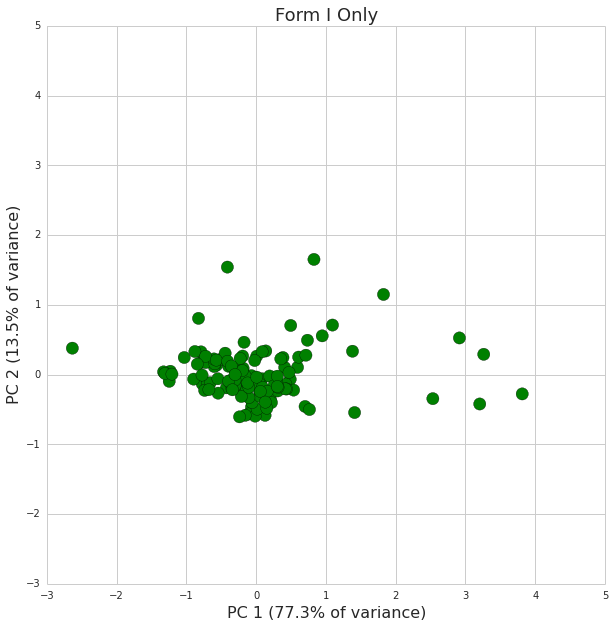

In [8]:
fig = plt.figure(figsize=(10,10))
colors = seaborn.color_palette()
seaborn.set_style('whitegrid')

transformed = fitted.transform(log_data)

plt.scatter(transformed[:, 0], transformed[:, 1], s=150, c='g')

plt.xlabel('PC 1 (%.1f%% of variance)' % pct_variance_explained[0], fontsize=16)
plt.ylabel('PC 2 (%.1f%% of variance)' % pct_variance_explained[1], fontsize=16)

plt.title('Form I Only', fontsize=18)
plt.xlim(-3, 5)
plt.ylim(-3, 5)

plt.show()

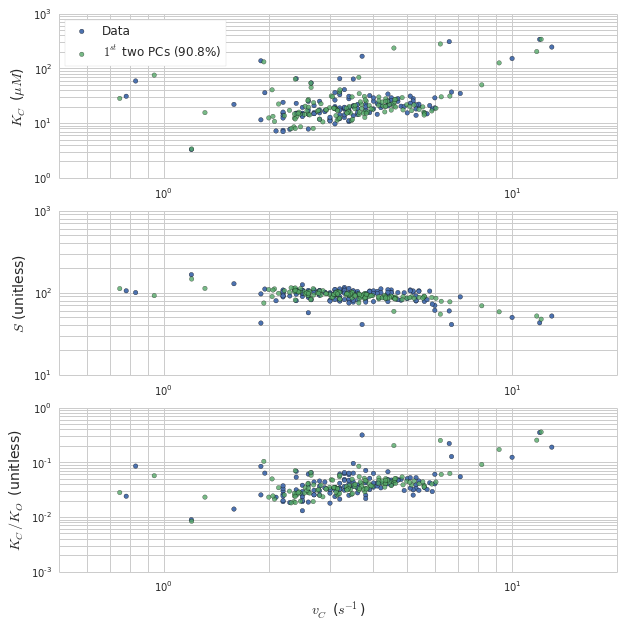

In [9]:
# Plotting the results of projecting onto the first principal component.
# For some reason my iPython won't do 3D figures right now.
transformed = fitted.transform(log_data)
reduced = fitted.inverse_transform(transformed)
reduced = np.exp(reduced)

fig = plt.figure(figsize=(10,10))
colors = seaborn.color_palette()
seaborn.set_style('whitegrid')

plt.subplot('311')
plt.xscale('log')
plt.yscale('log')
plt.scatter(data[:, 0], data[:, 1], c=colors[0], label='Data')
l = '$1^{st}$ two PCs (%.1f%%)' % np.sum(pct_variance_explained)
plt.scatter(reduced[:, 0], reduced[:, 1], c=colors[1], alpha=0.8, label=l)

plt.legend(loc=2, fontsize=12, frameon=True)
plt.ylabel('$K_C$ ($\mu M$)', fontsize=14)
plt.xlim(5e-1, 20)

plt.subplot('312')
plt.xscale('log')
plt.yscale('log')
plt.scatter(data[:, 0], data[:, 2], c=colors[0])
plt.scatter(reduced[:, 0], reduced[:, 2], c=colors[1], alpha=0.8)

plt.ylabel('$S$ (unitless)', fontsize=14)
plt.xlim(5e-1, 20)

plt.subplot('313')
plt.xscale('log')
plt.yscale('log')
plt.scatter(data[:, 0], data[:, 3], c=colors[0])
plt.scatter(reduced[:, 0], reduced[:, 3], c=colors[1], alpha=0.8)

plt.xlabel('$v_C$ ($s^{-1}$)', fontsize=14)
plt.ylabel('$K_C / K_O$ (unitless)', fontsize=14)
plt.xlim(5e-1, 20)

plt.show()

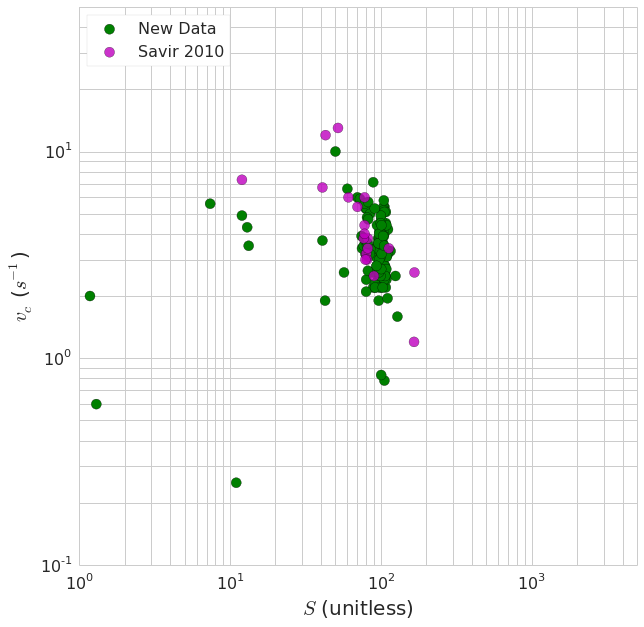

In [10]:
# Central correlation of Tcherkez2006 is S vs vC. 
# Plot data from Savir separate from new data.
figure = plt.figure(figsize=(10,10))
seaborn.set_style('whitegrid')

# loglog scale
plt.xscale('log')
plt.yscale('log')

# Note - axes are reversed from the Savir paper so above the line = good.
plt.scatter(nonsavir_df.S, nonsavir_df.Vc, c='g', s=100, label='New Data')
plt.scatter(savir_df.S, savir_df.Vc, c='m', s=100, label='Savir 2010', alpha=0.8)

plt.legend(loc=2, fontsize=16, frameon=True)
plt.xlabel('$S$ (unitless)', fontsize=20)
plt.ylabel('$v_c$ ($s^{-1}$)', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.ylim(1e-1, 50)
plt.xlim(1, 5e3)

plt.show()

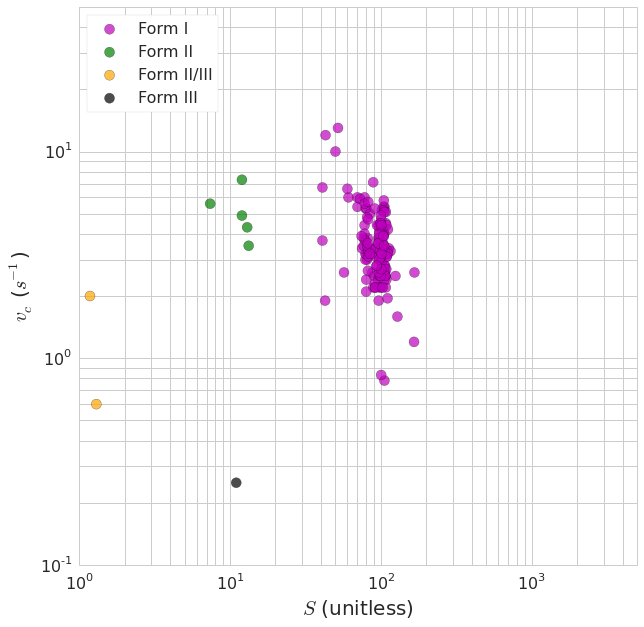

In [11]:
# Plot S vs vC. coloring by form. 
figure = plt.figure(figsize=(10,10))
seaborn.set_style('whitegrid')

plt.xscale('log')
plt.yscale('log')

colors = ['m', 'g', 'orange', 'k']
for i, (group, gdf) in enumerate(grouped_form):
    label = 'Form %s' % group
    c = colors[i]
    plt.scatter(gdf.S, gdf.Vc, c=c, s=100, label=label, alpha=0.7)

plt.legend(loc=2, fontsize=16, frameon=True)
plt.xlabel('$S$ (unitless)', fontsize=20)
plt.ylabel('$v_c$ ($s^{-1}$)', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.ylim(1e-1, 50)
plt.xlim(1, 5e3)

plt.show()

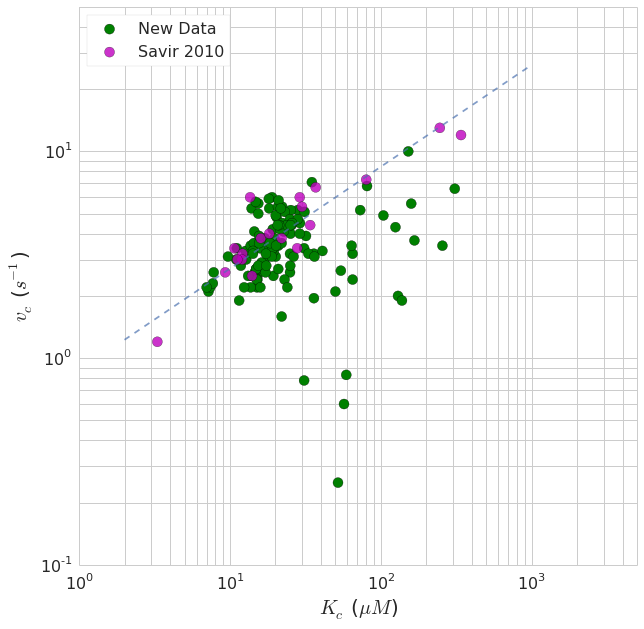

In [12]:
# Central correlation of Savir2010 is KC vs vC. 
# Here we plot data from Savir separate from new data.
figure = plt.figure(figsize=(10,10))
seaborn.set_style('whitegrid')

# loglog scale
plt.xscale('log')
plt.yscale('log')

# Note - axes are reversed from the Savir paper so above the line = good.
plt.scatter(nonsavir_df.Kc, nonsavir_df.Vc, c='g', s=100, label='New Data')
plt.scatter(savir_df.Kc, savir_df.Vc, c='m', s=100, label='Savir 2010', alpha=0.8)

# Plot Savir's power law for Kc vs. Vc
# Savir 2010 says Kc = 1.32 * Vc^2.03
# Therefore Vc = (Kc/1.32)^(1/2.03)
xs = np.arange(2, 1000, 5)
projected_Vcs = np.power(xs/1.32, 1.0/2.03)
plt.plot(xs, projected_Vcs, ls='--', alpha=0.7)

plt.legend(loc=2, fontsize=16, frameon=True)
plt.xlabel('$K_c$ ($\mu M$)', fontsize=20)
plt.ylabel('$v_c$ ($s^{-1}$)', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.ylim(1e-1, 50)
plt.xlim(1, 5e3)

plt.show()

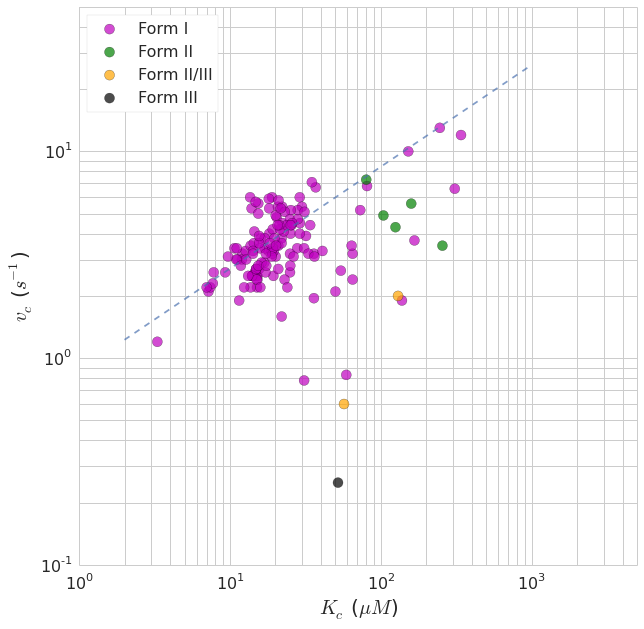

In [13]:
# Plot Kc vs. Vc coloring by RuBisCO form.
figure = plt.figure(figsize=(10,10))
seaborn.set_style('whitegrid')

plt.xscale('log')
plt.yscale('log')

colors = ['m', 'g', 'orange', 'k']
for i, (group, gdf) in enumerate(grouped_form):
    label = 'Form %s' % group
    c = colors[i]
    plt.scatter(gdf.Kc, gdf.Vc, c=c, s=100, label=label, alpha=0.7)

# Savir 2010 says Kc = 1.32 * Vc^2.03
# Therefore Vc = (Kc/1.32)^(1/2.03)
xs = np.arange(2, 1000, 5)
projected_Vcs = np.power(xs/1.32, 1.0/2.03)
plt.plot(xs, projected_Vcs, ls='--', alpha=0.7)

plt.legend(loc=2, fontsize=16, frameon=True)
plt.xlabel('$K_c$ ($\mu M$)', fontsize=20)
plt.ylabel('$v_c$ ($s^{-1}$)', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.ylim(1e-1, 50)
plt.xlim(1, 5e3)

plt.show()

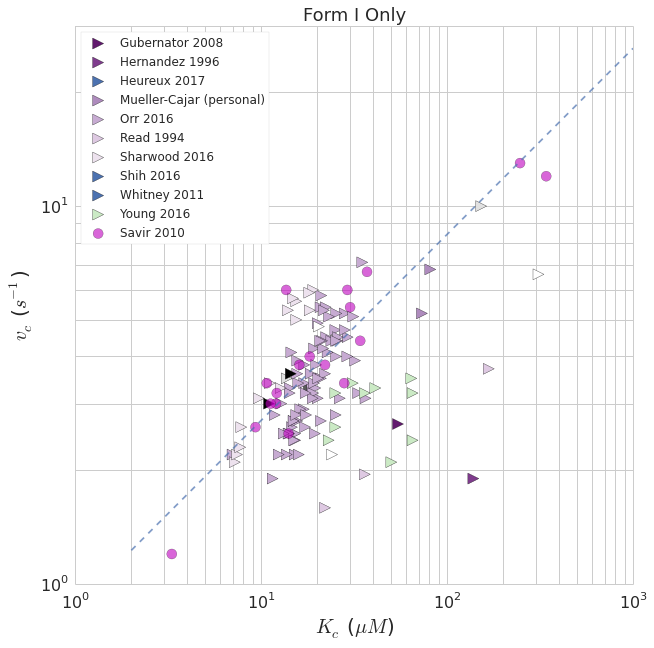

In [14]:
# Plot Kc vs. Vc for FI RuBisCOs alone, coloring by reference.
figure = plt.figure(figsize=(10,10))
seaborn.set_style('whitegrid')

plt.xscale('log')
plt.yscale('log')

colors = seaborn.color_palette("PRGn", 15)
fIs = grouped_form.get_group('I')
subset = np.logical_and(np.isfinite(fIs.Kc), np.isfinite(fIs.Vc))
fIs = fIs[subset]
fIs_nonsavir = fIs[fIs.savir == False]
grouped_ref = fIs_nonsavir.groupby('short_ref')
for i, (group, gdf) in enumerate(grouped_ref):
    plt.scatter(gdf.Kc, gdf.Vc, c=colors[i], s=120, marker='>', label=group)

savir_FIs = fIs[fIs.savir == True]
plt.scatter(savir_FIs.Kc, savir_FIs.Vc, c='m', s=100, alpha=0.6, label='Savir 2010')

# Savir 2010 says Kc = 1.32 * Vc^2.03
# Therefore Vc = (Kc/1.32)^(1/2.03)
xs = np.arange(2, 1000, 5)
projected_Vcs = np.power(xs/1.32, 1.0/2.03)
plt.plot(xs, projected_Vcs, ls='--', alpha=0.7)

plt.legend(loc=2, fontsize=12, frameon=True)
plt.title('Form I Only', fontsize=18)
plt.xlabel('$K_c$ ($\mu M$)', fontsize=20)
plt.ylabel('$v_c$ ($s^{-1}$)', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.ylim(1e0, 30)
plt.xlim(1, 1e3)

plt.show()

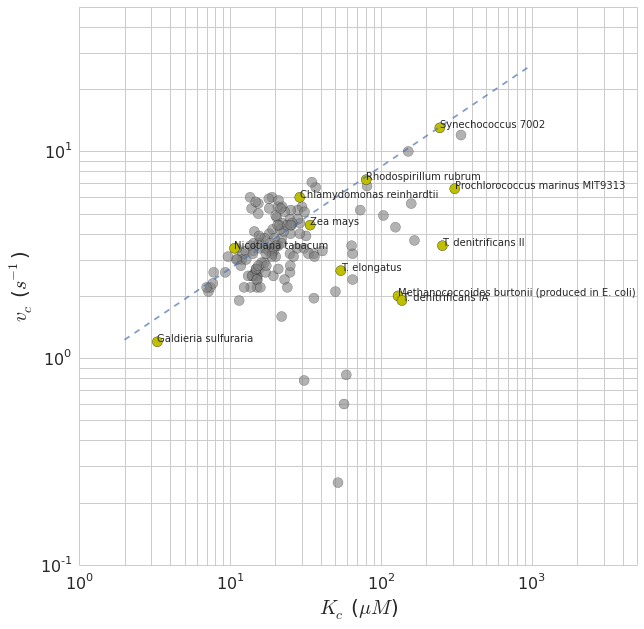

In [15]:
# Annotate "interesting" RuBisCOs, demarcated in the spreadsheet.
figure = plt.figure(figsize=(10,10))
seaborn.set_style('whitegrid')

plt.xscale('log')
plt.yscale('log')

# Group by manually curated "interesting" category mostly for famous RuBisCO isoforms
grouped_interesting = wt_only_df.groupby('interesting')
interesting = grouped_interesting.get_group(True)
others = grouped_interesting.get_group(False)

plt.scatter(others.Kc, others.Vc, c='grey', s=100, alpha=0.6)
plt.scatter(interesting.Kc, interesting.Vc, c='y', s=100)

# Comment out this loop for text-free diagram.
for i in interesting.index:
    r = interesting.loc[i]
    plt.text(r.Kc, r.Vc, i)

# Savir 2010 says Kc = 1.32 * Vc^2.03
# Therefore Vc = (Kc/1.32)^(1/2.03)
xs = np.arange(2, 1000, 5)
projected_Vcs = np.power(xs/1.32, 1.0/2.03)
plt.plot(xs, projected_Vcs, ls='--', alpha=0.7)

plt.xlabel('$K_c$ ($\mu M$)', fontsize=20)
plt.ylabel('$v_c$ ($s^{-1}$)', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.ylim(1e-1, 50)
plt.xlim(1, 5e3)

plt.show()

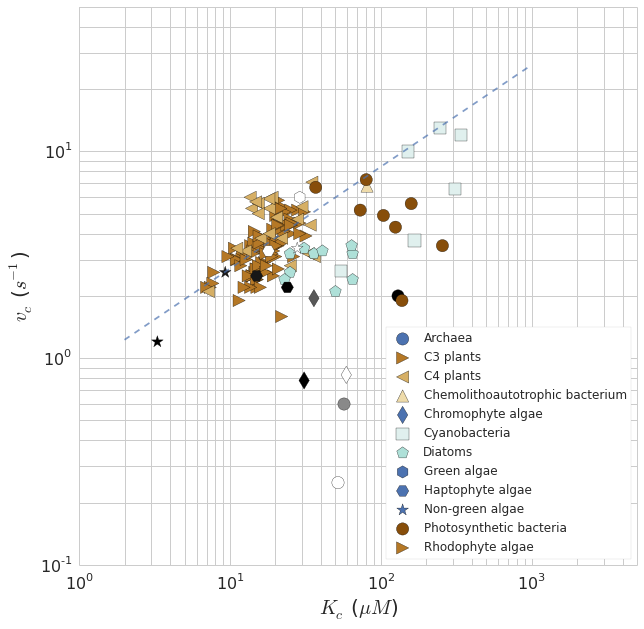

In [16]:
# Kc vs. Vc - show new data by taxonomic grouping of the organism. 
# Notice again the wide spread in photosynthetic bacteria being due to the
# very large deviations in measurements for the Rubrum FII enzyme.
figure = plt.figure(figsize=(10,10))
seaborn.set_style('whitegrid')
colors = seaborn.color_palette("BrBG", 10)

plt.xscale('log')
plt.yscale('log')

grouped_taxon = wt_only_df.groupby('Taxonomy')

for i, (group, gdf) in enumerate(grouped_taxon):
    marker = markers[i % len(markers)]
    c = colors[i % len(colors)]
    plt.scatter(gdf.Kc, gdf.Vc, label=group, s=150, c=c, marker=marker)

# Savir 2010 says Kc = 1.32 * Vc^2.03
# Therefore Vc = (Kc/1.32)^(1/2.03)
xs = np.arange(2, 1000, 5)
projected_Vcs = np.power(xs/1.32, 1.0/2.03)
plt.plot(xs, projected_Vcs, ls='--', alpha=0.7)

plt.legend(loc=4, fontsize=12, frameon=True)
plt.xlabel('$K_c$ ($\mu M$)', fontsize=20)
plt.ylabel('$v_c$ ($s^{-1}$)', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.ylim(1e-1, 50)
plt.xlim(1, 5e3)

plt.show()

In [17]:
# KC vs. VC correlation over entire dataset
KCs = np.log(wt_only_df.Kc)
vCs = np.log(wt_only_df.Vc)
mask = ~np.isnan(KCs) & ~np.isnan(vCs)
KCs = KCs[mask]
vCs = vCs[mask]

# regress
slope, intercept, r_val, p_val, stderr = linregress(KCs, vCs)
r2 = r_val**2
print 'R^2 =', r2
prefactor = np.exp(intercept)
exponent = slope
xs = np.arange(2, 1000, 5)
predicted_vCs = prefactor * np.power(xs, exponent)
print 'y = %.3g x^(%.3f)' % (prefactor, exponent)

R^2 = 0.0662377605249
y = 2.02 x^(0.163)


In [18]:
# KC vs. VC correlation for C3 & C4 plants
c3c4plant_data = wt_only_df[wt_only_df.Taxonomy.isin(['C3 plants', 'C3 plants'])]
KCs = np.log(c3c4plant_data.Kc)
vCs = np.log(c3c4plant_data.Vc)
mask = ~np.isnan(KCs) & ~np.isnan(vCs)
KCs = KCs[mask]
vCs = vCs[mask]

# regress
slope, intercept, r_val, p_val, stderr = linregress(KCs, vCs)
r2 = r_val**2
print 'R^2 =', r2
prefactor = np.exp(intercept)
exponent = slope
xs = np.arange(2, 1000, 5)
predicted_vCs = prefactor * np.power(xs, exponent)
print 'y = %.3g x^(%.3f)' % (prefactor, exponent)

R^2 = 0.490016564351
y = 0.658 x^(0.573)


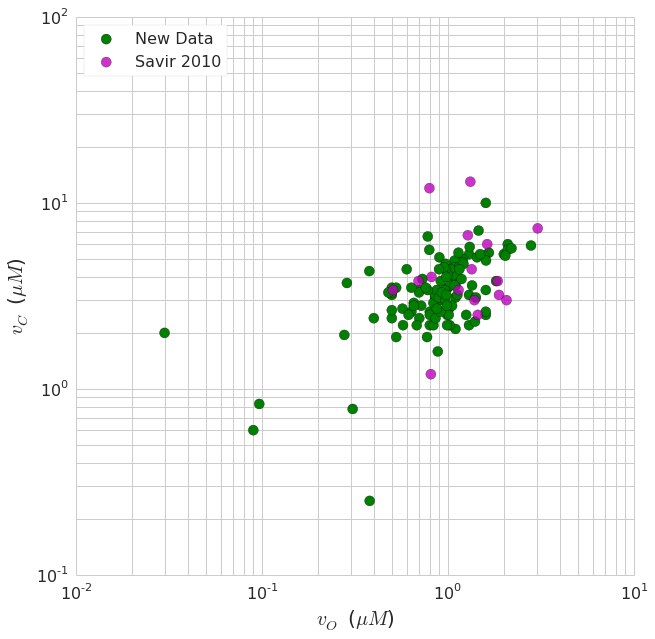

In [19]:
# Is vO still uncorrelated with vC as suggested by Savir2010?
figure = plt.figure(figsize=(10,10))
seaborn.set_style('whitegrid')

# loglog scale
plt.xscale('log')
plt.yscale('log')

plt.scatter(nonsavir_df.Vo, nonsavir_df.Vc, c='g', s=100, label='New Data')
plt.scatter(savir_df.Vo, savir_df.Vc, c='m', s=100, label='Savir 2010', alpha=0.8)

plt.legend(loc=2, fontsize=16, frameon=True)
plt.xlabel('$v_O$ ($\mu M$)', fontsize=20)
plt.ylabel('$v_C$ ($\mu M$)', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.show()

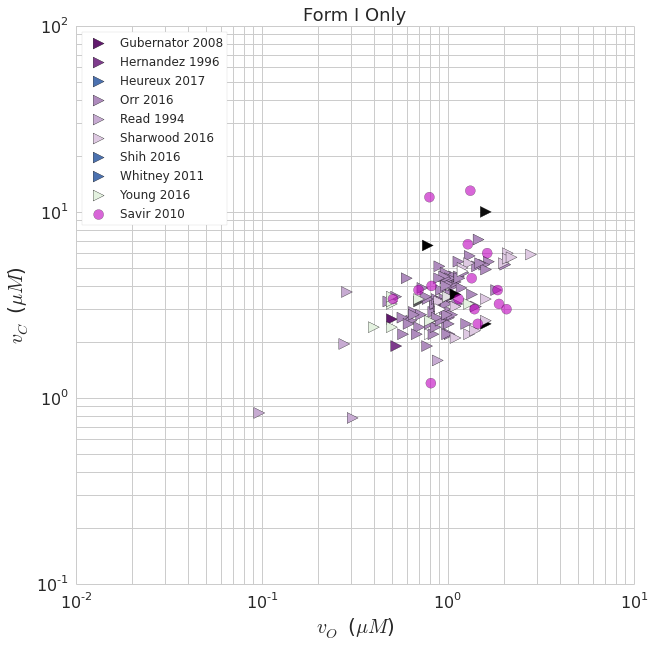

In [20]:
# Vo vs Vc but for FI enzymes only.
figure = plt.figure(figsize=(10,10))
seaborn.set_style('whitegrid')

plt.xscale('log')
plt.yscale('log')

colors = seaborn.color_palette("PRGn", 15)
fIs = grouped_form.get_group('I')
subset = np.logical_and(np.isfinite(fIs.Vc), np.isfinite(fIs.Vo))
fIs = fIs[subset]
fIs_nonsavir = fIs[fIs.savir == False]
grouped_ref = fIs_nonsavir.groupby('short_ref')
for i, (group, gdf) in enumerate(grouped_ref):
    c = colors[i]
    plt.scatter(gdf.Vo, gdf.Vc, c=c, s=120, marker='>', label=group)

savir_FIs = fIs[fIs.savir == True]
plt.scatter(savir_FIs.Vo, savir_FIs.Vc, c='m', s=100, alpha=0.6, label='Savir 2010')

plt.legend(loc=2, fontsize=12, frameon=True)
plt.title('Form I Only', fontsize=18)
plt.xlabel('$v_O$ ($\mu M$)', fontsize=20)
plt.ylabel('$v_C$ ($\mu M$)', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.show()

In [21]:
# vO vs. vC correlation over entire dataset
vOs = np.log(wt_only_df.Vo)
vCs = np.log(wt_only_df.Vc)
mask = ~np.isnan(vOs) & ~np.isnan(vCs)
vOs = vOs[mask]
vCs = vCs[mask]

# regress
slope, intercept, r_val, p_val, stderr = linregress(vOs, vCs)
r2 = r_val**2
print 'R^2 =', r2
prefactor = np.exp(intercept)
exponent = slope
print 'y = %.3g x^(%.3f)' % (prefactor, exponent)

R^2 = 0.303990005471
y = 3.49 x^(0.456)


In [22]:
# vO vs. vC correlation for FI
FIs = wt_only_df[wt_only_df.form_text == 'I']
vOs = np.log(FIs.Vo)
vCs = np.log(FIs.Vc)
mask = ~np.isnan(vOs) & ~np.isnan(vCs)
vOs = vOs[mask]
vCs = vCs[mask]

# regress
slope, intercept, r_val, p_val, stderr = linregress(vOs, vCs)
r2 = r_val**2
print 'R^2 =', r2
prefactor = np.exp(intercept)
exponent = slope
print 'y = %.3g x^(%.3f)' % (prefactor, exponent)

R^2 = 0.284470288713
y = 3.49 x^(0.474)


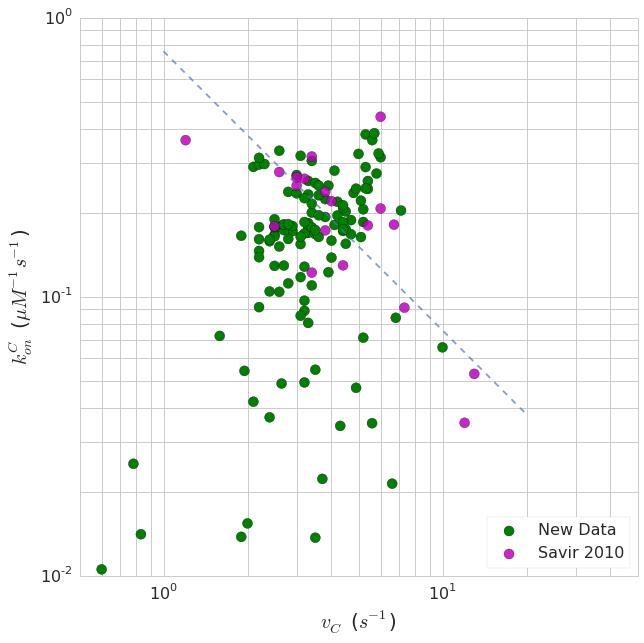

In [23]:
# Mechanistic proposal #1 from Savir - Vc vs. k_onC graph.
figure = plt.figure(figsize=(10,10))
seaborn.set_style('whitegrid')
colors = seaborn.color_palette("BrBG", 10)

plt.xscale('log')
plt.yscale('log')

plt.scatter(nonsavir_df.Vc, nonsavir_df.kon_C, c='g', s=100, label='New Data')
plt.scatter(savir_df.Vc, savir_df.kon_C, c='m', s=100, alpha=0.85, label='Savir 2010')

# Savir 2010 says konC = vc/KC = vc/(1.32*vc^2) = 0.757/vc
xs = np.arange(1, 20, 0.1)
projected_konC = 0.757/xs
plt.plot(xs, projected_konC, ls='--', alpha=0.7)

plt.legend(loc=4, fontsize=16, frameon=True)
plt.xlabel('$v_C$ ($s^{-1}$)', fontsize=20)
plt.ylabel('$k_{on}^C$ ($\mu M^{-1} s^{-1}$)', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.ylim(1e-2, 1)
plt.xlim(0.5, 50)

plt.show()

In [24]:
# vC vs. konC correlation over entire dataset
vCs = np.log(wt_only_df.Vc)
konCs = np.log(wt_only_df.kon_C)
mask = ~np.isnan(vCs) & ~np.isnan(konCs)
vCs = vCs[mask]
konCs = konCs[mask]

# regress
slope, intercept, r_val, p_val, stderr = linregress(vCs, konCs)
r2 = r_val**2
print 'R^2 =', r2
prefactor = np.exp(intercept)
exponent = slope
print 'y = %.3g x^(%.3f)' % (prefactor, exponent)

R^2 = 0.130346131588
y = 0.0691 x^(0.592)


In [25]:
# vC vs. konC correlation just for FIs
FIs = wt_only_df[wt_only_df.form_text == 'I']
vCs = np.log(FIs.Vc)
konCs = np.log(FIs.kon_C)
mask = ~np.isnan(vCs) & ~np.isnan(konCs)
vCs = vCs[mask]
konCs = konCs[mask]

# regress
slope, intercept, r_val, p_val, stderr = linregress(vCs, konCs)
r2 = r_val**2
print 'R^2 =', r2
prefactor = np.exp(intercept)
exponent = slope
print 'y = %.3g x^(%.3f)' % (prefactor, exponent)

R^2 = 0.0415398923278
y = 0.107 x^(0.319)


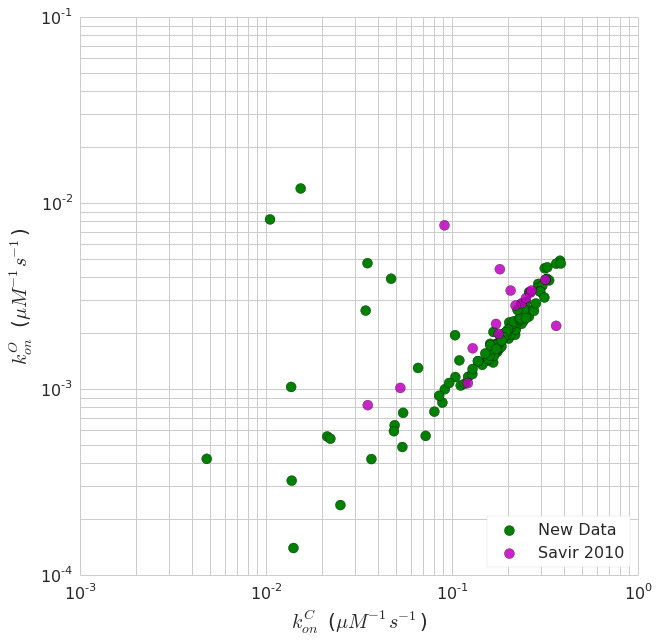

In [26]:
# Mechanistic proposal #2 from Savir - k_onC vs k_onO
figure = plt.figure(figsize=(10,10))
seaborn.set_style('whitegrid')
colors = seaborn.color_palette("BrBG", 10)

plt.xscale('log')
plt.yscale('log')

plt.scatter(nonsavir_df.kon_C, nonsavir_df.kon_O, c='g', s=100, label='New Data')
plt.scatter(savir_df.kon_C, savir_df.kon_O, c='m', s=100, alpha=0.85, label='Savir 2010')

# NOTE: can't find the prefactor for this power law in the paper. 
# Can recalculate by doing regression from the Savir data but didn't have time before presentation. 
# Would prefer to calculate from numbers reported in the PNAS paper. Probably possible, will take some thought.

plt.legend(loc=4, fontsize=16, frameon=True)
plt.xlabel('$k_{on}^C$ ($\mu M^{-1} s^{-1}$)', fontsize=20)
plt.ylabel('$k_{on}^O$ ($\mu M^{-1} s^{-1}$)', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.ylim(1e-4, .1)
plt.xlim(1e-3, 1)

plt.show()

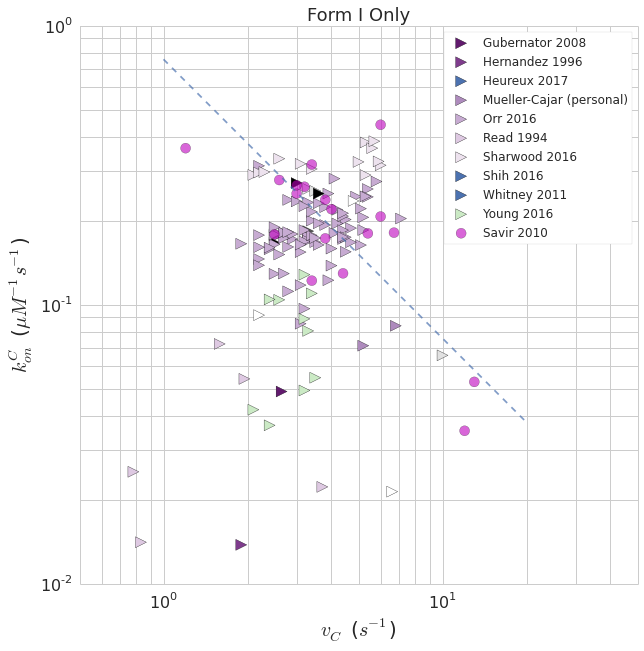

In [27]:
# Mechanistic proposal #1 from Savir - Vc vs. k_onC only for FI enzymes, color by reference
figure = plt.figure(figsize=(10,10))
seaborn.set_style('whitegrid')

plt.xscale('log')
plt.yscale('log')

colors = seaborn.color_palette("PRGn", 15)
fIs = grouped_form.get_group('I')
subset = np.logical_and(np.isfinite(fIs.Vc), np.isfinite(fIs.kon_C))
fIs = fIs[subset]
fIs_nonsavir = fIs[fIs.savir == False]
grouped_ref = fIs_nonsavir.groupby('short_ref')
for i, (group, gdf) in enumerate(grouped_ref):
    c = colors[i]
    plt.scatter(gdf.Vc, gdf.kon_C, c=c, s=120, marker='>', label=group)

savir_FIs = fIs[fIs.savir == True]
plt.scatter(savir_FIs.Vc, savir_FIs.kon_C, c='m', s=100, alpha=0.6, label='Savir 2010')

# Savir 2010 says konC = vc/KC = vc/(1.32*vc^2) = 0.757/vc
xs = np.arange(1, 20, 0.1)
projected_konC = 0.757/xs
plt.plot(xs, projected_konC, ls='--', alpha=0.7)

plt.title('Form I Only', fontsize=18)
plt.legend(loc=1, fontsize=12, frameon=True)
plt.xlabel('$v_C$ ($s^{-1}$)', fontsize=20)
plt.ylabel('$k_{on}^C$ ($\mu M^{-1} s^{-1}$)', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.ylim(1e-2, 1)
plt.xlim(0.5, 50)

plt.show()

In [28]:
# For mechanistic proposal 2
# Attempt to fit a power law at the boundary by taking data from the refs that make up the boundary
fIs = grouped_form.get_group('I')
finite_ones = np.logical_and(np.isfinite(fIs.kon_C), np.isfinite(fIs.kon_O))
nz_ones = np.logical_and(fIs.kon_C > 0, fIs.kon_O > 0)
subset = np.logical_and(finite_ones, nz_ones)
fIs_mech2 = fIs[subset]

refs = [u'Sharwood 2016', u'Young 2016', u'Read 1994', u'Heureux 2017',  u'Orr 2016']
only_refs = fIs_mech2[fIs_mech2.short_ref.isin(refs)]

sample_xs = np.log(only_refs.kon_C)
sample_ys = np.log(only_refs.kon_O)

# TODO: should be doing this with robust regression because we expect asymmetric outliers
# biased to the left of the curve. This will do for now to illustrate significance, 
# but I would not trust the exponent, as is evident in the plot below. 
slope, intercept, r_val, p_val, stderr = linregress(sample_xs, sample_ys)
r2 = r_val**2
print 'ln(y) = %.2g ln(x) + %.2g; R = %.2f; P = %.2g' % (slope, intercept, r_val, p_val)
print 'stderr', stderr

# Power law
prefactor = np.exp(intercept)
exponent = slope
print 'y = %.3g x^(%.3f)' % (prefactor, exponent)
konCs = np.arange(1e-2, 1, 0.001)
predicted_konOs = prefactor * np.power(konCs, exponent)

ln(y) = 0.98 ln(x) + -4.6; R = 0.96; P = 2.8e-61
stderr 0.0264731228796
y = 0.01 x^(0.979)


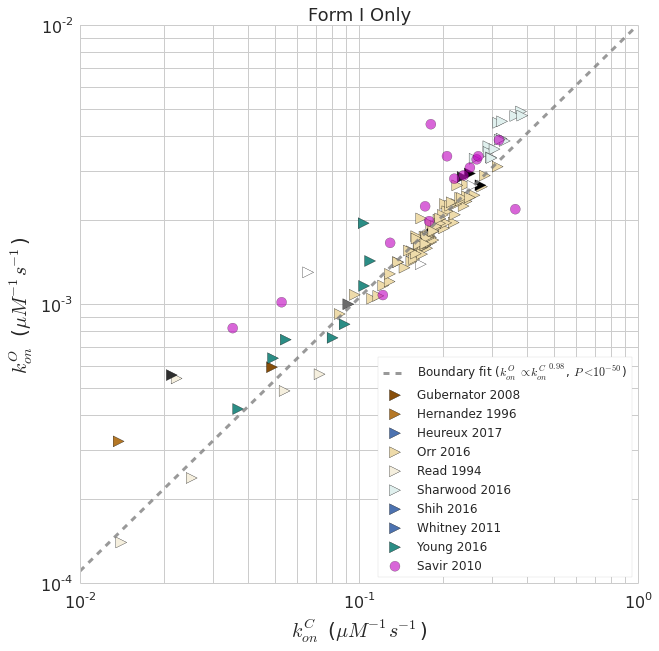

In [29]:
# Mechanistic proposal #2 from Savir - k_onC vs k_onO only for FI enzymes, color by reference
figure = plt.figure(figsize=(10,10))
seaborn.set_style('whitegrid')

plt.xscale('log')
plt.yscale('log')

colors = seaborn.color_palette("BrBG", 10)
fIs_nonsavir = fIs_mech2[fIs_mech2.savir == False]
grouped_ref = fIs_nonsavir.groupby('short_ref')
for i, (group, gdf) in enumerate(grouped_ref):
    c = colors[i]
    plt.scatter(gdf.kon_C, gdf.kon_O, c=c, s=120, marker='>', label=group)

savir_FIs = fIs_mech2[fIs_mech2.savir == True]
plt.scatter(savir_FIs.kon_C, savir_FIs.kon_O, c='m', s=100, alpha=0.6, label='Savir 2010')

fit_label = 'Boundary fit ($k_{on}^O \\propto {k_{on}^C}^{%.2f}$, $P < 10^{-50}$)' % exponent
plt.plot(konCs, predicted_konOs, ls='--', c='grey', lw=3, alpha=0.8, label=fit_label)

plt.title('Form I Only', fontsize=18)
plt.legend(loc=4, fontsize=12, frameon=True)
plt.xlabel('$k_{on}^C$ ($\mu M^{-1} s^{-1}$)', fontsize=20)
plt.ylabel('$k_{on}^O$ ($\mu M^{-1} s^{-1}$)', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.ylim(1e-4, 1e-2)
plt.xlim(1e-2, 1)

plt.show()

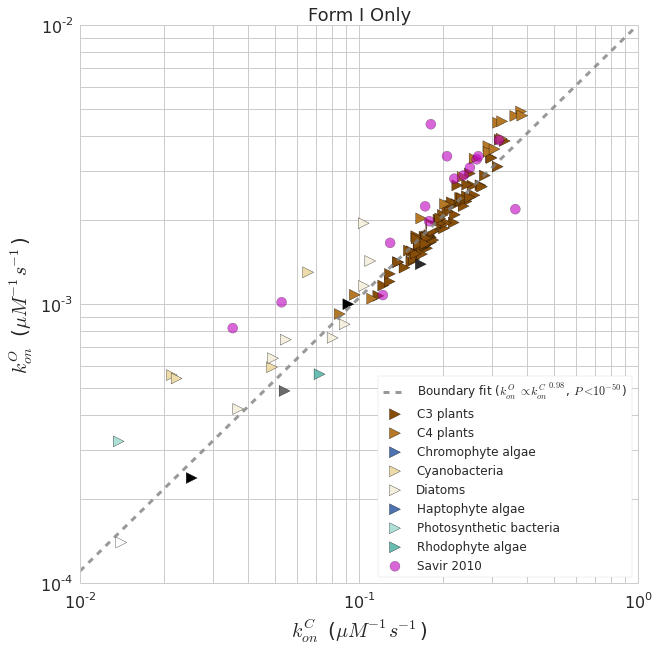

In [30]:
# Mechanistic proposal #2 from Savir - k_onC vs k_onO only for FI enzymes, color by reference
figure = plt.figure(figsize=(10,10))
seaborn.set_style('whitegrid')

plt.xscale('log')
plt.yscale('log')

colors = seaborn.color_palette("BrBG", 10)
fIs_nonsavir = fIs_mech2[fIs_mech2.savir == False]
grouped_ref = fIs_nonsavir.groupby('Taxonomy')
for i, (group, gdf) in enumerate(grouped_ref):
    c = colors[i]
    plt.scatter(gdf.kon_C, gdf.kon_O, c=c, s=120, marker='>', label=group)

savir_FIs = fIs_mech2[fIs_mech2.savir == True]
plt.scatter(savir_FIs.kon_C, savir_FIs.kon_O, c='m', s=100, alpha=0.6, label='Savir 2010')

fit_label = 'Boundary fit ($k_{on}^O \\propto {k_{on}^C}^{%.2f}$, $P < 10^{-50}$)' % exponent
plt.plot(konCs, predicted_konOs, ls='--', c='grey', lw=3, alpha=0.8, label=fit_label)

plt.title('Form I Only', fontsize=18)
plt.legend(loc=4, fontsize=12, frameon=True)
plt.xlabel('$k_{on}^C$ ($\mu M^{-1} s^{-1}$)', fontsize=20)
plt.ylabel('$k_{on}^O$ ($\mu M^{-1} s^{-1}$)', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.ylim(1e-4, 1e-2)
plt.xlim(1e-2, 1)

plt.show()

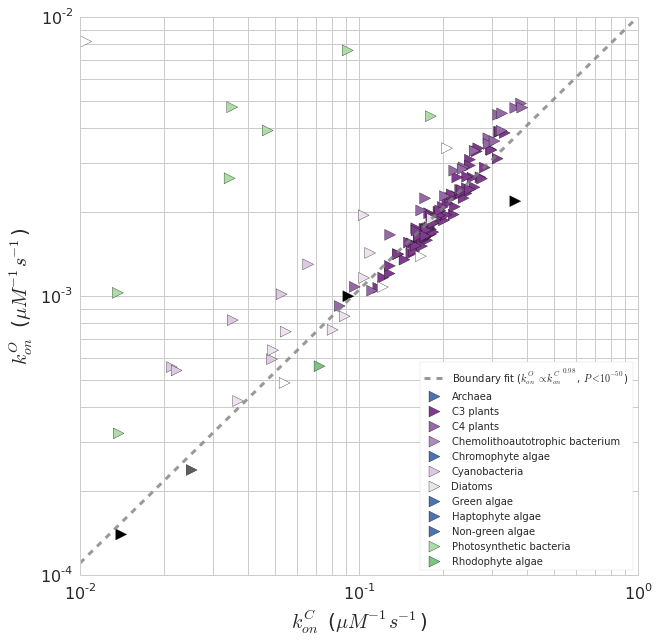

In [31]:
# Mechanistic proposal #2 from Savir - k_onC vs k_onO for all data, color by taxonomy
figure = plt.figure(figsize=(10,10))
seaborn.set_style('whitegrid')

plt.xscale('log')
plt.yscale('log')

colors = seaborn.color_palette("PRGn", n_colors=15)
grouped_ref = wt_only_df.groupby('Taxonomy')
for i, (group, gdf) in enumerate(grouped_ref):
    c = colors[i]
    plt.scatter(gdf.kon_C, gdf.kon_O, s=120, c=c, marker='>', label=group)

#savir_all_df = wt_only_df[wt_only_df.savir == True]
#plt.scatter(savir_all_df.kon_C, savir_all_df.kon_O, c='m', s=100, alpha=0.6, label='Savir 2010')

fit_label = 'Boundary fit ($k_{on}^O \\propto {k_{on}^C}^{%.2f}$, $P < 10^{-50}$)' % exponent
plt.plot(konCs, predicted_konOs, ls='--', c='grey', lw=3, alpha=0.8, label=fit_label)

plt.legend(loc=4, fontsize=10, frameon=True)
plt.xlabel('$k_{on}^C$ ($\mu M^{-1} s^{-1}$)', fontsize=20)
plt.ylabel('$k_{on}^O$ ($\mu M^{-1} s^{-1}$)', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.ylim(1e-4, 1e-2)
plt.xlim(1e-2, 1)

plt.show()